# Introduction

This notebook expands upon the first and second notebooks in a series that builds a framework for modeling polymer chain adsorption on nanoparticles. This notebook assumes that the first two notebooks have  been studied and understood.<br><br>In this notebook, we will use the function framework established in notebook 2 to perform automated sweeps of parameters.

# Imports, evironment, setting some variables

In [1]:
import numpy as np
from copy import copy
import os

### set to single GPU

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### default arguments

In [3]:
#specify arguments for model generation
args_default = {}
args_default["ld"] = 1024
args_default["vd"] = 512
args_default["radius_nm"] = 17
args_default["PhysSize_nm_per_voxel"] = 0.5
args_default["S0"] = 0.5
args_default["S_slope_per_nm"] = -0.02

args_default["energies"] = np.array([260, 270])
args_default["energies"] = np.append(args_default["energies"], np.arange(275, 283, 1), axis=0)
args_default["energies"] = np.append(args_default["energies"], np.arange(283, 291, 0.1), axis=0)
args_default["energies"] = np.append(args_default["energies"], np.arange(291, 305, 1), axis=0)

# Import indexes of refraction for polymers and SiO2

For polymers, we will import only the PS index of refraction from the first notebook.

In [4]:
from pandas import read_csv
from NRSS.morphology import OpticalConstants
ps_uni = read_csv("PS_anisotropic_milner_July2024.txt", sep=",")
sio2_uni = read_csv("siox_iso_NIST_Jan2024.txt", sep=",")

args_default["oc_polymer"] = OpticalConstants.calc_constants(args_default["energies"], ps_uni, name="PS")
args_default["oc_particle"] = OpticalConstants.calc_constants(args_default["energies"], sio2_uni, name="SiO2")

CyRSoXS
Size of Real               : 4
Maximum Number Of Material : 32
 __________________________________________________________________________________________________
|                                 Thanks for using CyRSoXS                                        |
|--------------------------------------------------------------------------------------------------|
|  Copyright          : Iowa State University                                                      |
|  License            : NIST                                                                       |
|  Acknowledgement    : ONR MURI                                                                   |
|                                                                                                  |
|  Developed at Iowa State University in collaboration with NIST                                   |
|                                                                                                  |
|  Please cite the fol

<div class="alert alert-block alert-success"><b>Tip:</b> Note I've now made these indices the default ones. This isn't critical, it's mostly so when we copy args_default below, the indices come along for the ride.
</div>

<Axes: title={'center': 'SiO2'}, xlabel='Energy'>

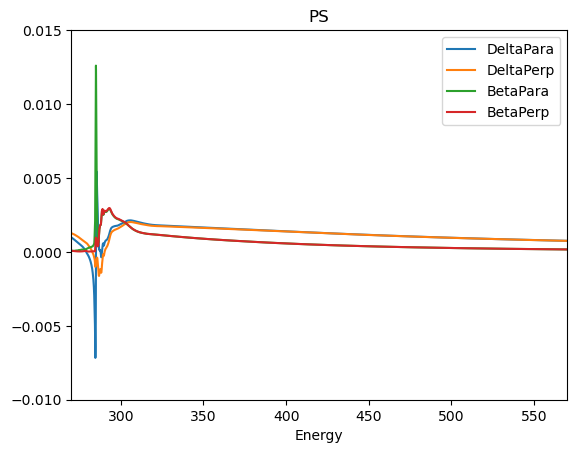

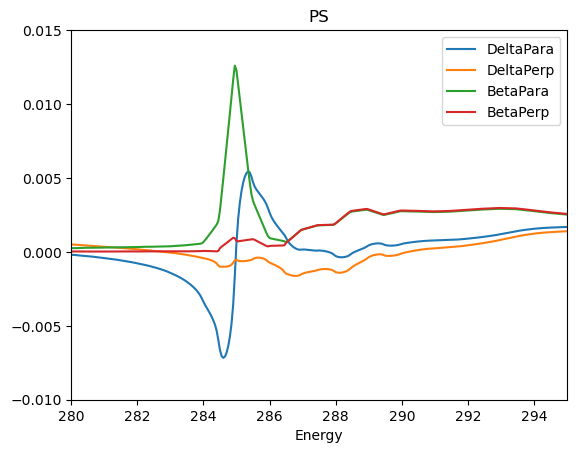

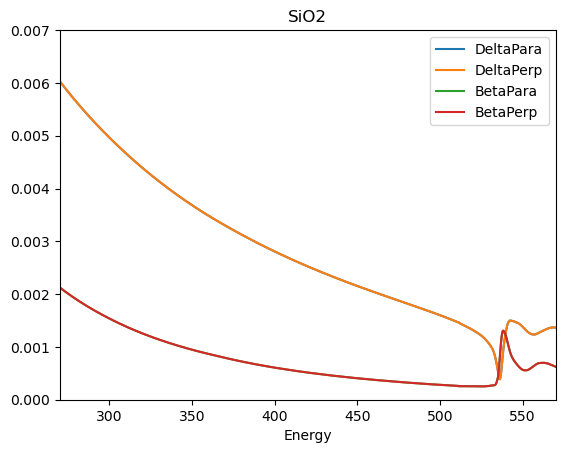

In [5]:
ps_uni.plot(x="Energy", xlim = (270,570), ylim = (-.01,0.015), title = "PS")
ps_uni.plot(x="Energy", xlim = (280,295), ylim = (-.01,0.015), title = "PS")

sio2_uni.plot(x="Energy", xlim = (270,570), ylim = (0,0.007), title = "SiO2")

<div class="alert alert-block alert-success"><b>Tip:</b> Even when you know them by heart, it is a best-practice to always plot the index of refraction that you're using in your model, just in case it has changed somehow on disk, or perhaps there was a Python library update that caused it to import weird.
</div>

# Functions from earlier notebooks

Rather than copypasting all the functions from notebooks 1 and 2 into a giant notebook cell, I've moved them to a separate python file: polymer_adsorption_functions01.py <br><br> We will import the function we need, and since the other functions are nested in it, they will be imported too. <br><br> Generally, it's a good idea to start a *.py file in addition to your Jupyter notebook, and move functions once they are "complete" to the *.py, to save your sanity from the scrolling if for nothing else. If you need to revise or refactor the functions, sometimes you need to bring them back into Jupyter and potentially pull them apart into individual cells, essentially the reverse of this notebook course.

In [6]:
# note that it finds the .py file because it's in the same directory as the notebook
# if you want to have the *.py in a different directory, you'll need to change the python path to find the import
from polymer_adsorption_functions01 import adsorbed_polymer_run_save
from polymer_adsorption_functions01 import EulerStyle

args_default["euler_style"] = EulerStyle.RADIAL

/home/deand/mambaforge/envs/deand/lib/python3.10/site-packages/PyHyperScattering/util.py:4: UserWarning: Could not import package for interactive integration utils.  Install holoviews and scikit-image.
  from PyHyperScattering import IntegrationUtils


# Function that sweeps an argument across values

In [7]:
def adsorbed_polymer_sweep(args, swept_arg, values, file_prefix = ""):
    # note that the default value of the file_prefix is an empty string
    # this prefix is here just if you want to mark the filenames with a special marker like the date,
    # or other values you might have set outside this function like euler style

    # add a couple of values here to args including the swept args and values
    # this is mostly to save for after-simulation analysis
    args["swept_arg"] = swept_arg
    args["swept_values"] = values
    
    # enumerate provides two values, the index (0,1,2,3, etc) and the value.
    # we use that here so that the variable i can keep track of which value we're on
    # and we'll use that in the filename
    for i, value in enumerate(values):
        # set the swept argument in the args dictionary to the current value    
        args[swept_arg] = value
        
        # set the filename to the concatenation of the prefix, the swept argument, and the index
        # the index is zero padded to 2 digits so that the filename is always the same length
        args["filename"] = file_prefix + swept_arg + "_" + str(i).zfill(2) + ".pkl"
        
        #run the model and pickle the result
        adsorbed_polymer_run_save(args)

# Running a sweep

This is for the "set it and go to lunch" kind of run

In [8]:
import numpy as np

args = copy(args_default)
args["euler_style"] = EulerStyle.TANGENTIAL_LAT

# we could vary any parameter
swept_arg = "radius_nm"

# the values you want to look at could be generated many ways. 
# a list of values could be made like this
# values = np.array([10, 15, 20, 25, 30, 35, 40, 45])

# # you could use np.linspace
# values = np.linspace(10, 45, 8)

# # you could use np.arange
# values = np.arange(10, 45, 5)

# # you could use np.logspace
# values = np.logspace(1, 3, 8)

# # you could use np.geomspace
# values = np.geomspace(10, 45, 8)

# my favorite is linspace
values = np.linspace(10, 45, 16)

file_prefix = "tutorial_tanlat_"

# the syntax below is normal for python. We've used the same names in this cell as we used
# in the function. But it's important to remember that these are passed as arguments - 
# we are not relying on them to be global variables

adsorbed_polymer_sweep(args = args, swept_arg = swept_arg, values = values, file_prefix = file_prefix)

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

# Running a sweep of sweeps

This is for the "set it and go home for the evening" kind of run.

In [9]:

swept_arg_list = ["radius_nm", "S0", "S_slope_per_nm"]
values_list = [
    np.linspace(10, 45, 16), # these are the swept values for radius_nm
    np.linspace(0, 1, 16), # these are the swept values for S0
    np.linspace(-0.1, 0.0, 16), #these are the swept values for S_slope_per_nm
]


file_prefix = "tutorial_ssweeps_"

# zip below creates a list of pairs from two lists
for swept_arg, values in zip(swept_arg_list, values_list):

    # get a fresh copy of args each iteration
    args = copy(args_default)
    args["euler_style"] = EulerStyle.TANGENTIAL_LAT    
    adsorbed_polymer_sweep(
        args=args, swept_arg=swept_arg, values=values, file_prefix=file_prefix
    )

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]

All material checks have passed
All objects have been validated successfully. You can run your simulation

 [STAT] Executing: 

Number of CUDA devices:1
[INFO] [GPU = Quadro RTX 8000] : 260eV -> 304eV
 [STAT] Energy = 260 starting 
 [STAT] Energy = 270 starting 
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 283.1 starting 
 [STAT] Energy = 283.2 starting 
 [STAT] Energy = 283.3 starting 
 [STAT] Energy = 283.4 starting 
 [STAT] Energy = 283.5 starting 
 [STAT] Energy = 283.6 starting 
 [STAT] Energy = 283.7 starting 
 [STAT] Energy = 283.8 starting 
 [STAT] Energy = 283.9 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 284.1 starting 
 [STAT] Energy = 284.2 starting 
 [STAT] Energy = 284.3 starting 
 [STAT] Energy = 284.4 starting

  0%|          | 0/104 [00:00<?, ?it/s]